In [2854]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import iqr
import pandas as pd
import random

In [2855]:
# Read in data
data = pd.read_csv('labels_cropped.txt')
len(data)

91

In [2856]:
data = data[data.ClusterSize>=10]
len(data)

85

In [2857]:
# Remove duplicates
data = data.drop_duplicates(subset=data.columns[1:])
len(data)

84

In [2858]:
X = np.array([data.AvgLength,data.StdAngle]).T
# # X = np.array([data.MedLength,data.Skew]).T
# # X = data.Avglength.as_matrix().reshape(-1,1)
y = data.Label.as_matrix()

In [2859]:
# data = data.reindex(np.random.permutation(data.index))

# cutoff = int(0.7*len(data))

# train_data = data[:cutoff]
# test_data = data[cutoff:]

In [2860]:
print len(np.where(y==1)[0])
print len(np.where(y==0)[0])

39
45


In [2861]:
# X_train = np.array([train_data.MedLength,train_data.IqrAngle]).T
# X_test = np.array([test_data.MedLength,test_data.IqrAngle]).T
# y_train = train_data.Label.as_matrix()
# y_test = test_data.Label.as_matrix()

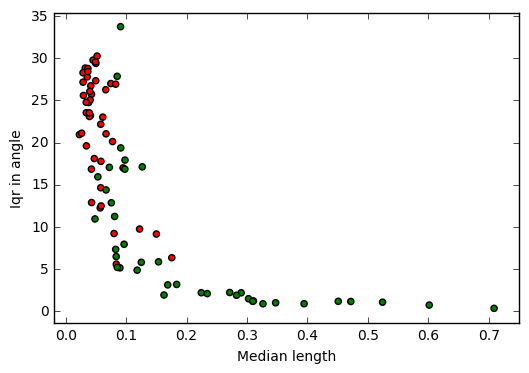

In [2862]:
colors = ['g' if label else 'r' for label in y]

# plt.subplot(211)
plt.scatter((X[:,0]),X[:,1],c=colors)
plt.axis('equal')
plt.xlabel('Median length')
plt.ylabel('Iqr in angle')
# plt.plot([x_dec,x_dec],[np.min(data.Stdangle),np.max(data.Stdangle)])
plt.axis('tight')
plt.show()

# colors_pred = ['g' if label else 'r' for label in y_pred]

# plt.subplot(212)
# plt.scatter(X[:,0],X[:,1],c=colors_pred)
# plt.axis('equal')
# plt.xlabel('Average length')
# plt.ylabel('St. dev. in angle')
# # plt.plot([x_dec,x_dec],[np.min(data.Stdangle),np.max(data.Stdangle)])
# plt.axis('tight')
# plt.show()


In [2863]:
# Look at some edge cases in the data

# Large length, large angle spread
data[(data.MedLength>=0.1) & (data.IqrAngle>60)]

# Large angle spread
data[data.IqrAngle>60]
# these contains images with creeks running through

# Positive labels with small lengths and medium spread in angle
data[(data.Label==1) & (data.MedLength<0.1) & (data.IqrAngle>20) & (data.IqrAngle<60)].sort_values('ImgID')
# these contains images irregular shape, creeks running through, or multiple groups of angles

# Positive labels with small lengths and small spread in angle
data[(data.Label==1) & (data.MedLength<0.1) & (data.IqrAngle<=20)].sort_values('ImgID')
# these have small gaps (lines,pipes) running through part of the image

# Positive labels with large lengths and small spread in angle
data[(data.Label==1) & (data.MedLength>=0.1) & (data.IqrAngle<=20)].sort_values('ImgID')
# these are the nice patterns 


data[(data.Label==1) & (data.AvgLength<0.1) & (data.StdAngle>20)].sort_values('ImgID')



,ImgID,Label,ClusterSize,AvgLength,MedLength,StdAngle,IqrAngle,IqrangleTop
50,110_nir_2016-06-20.png,1,33,0.090706,0.072585,33.764082,53.130102,0.00000
82,74_nir_2013-08-11.png,1,64,0.085060,0.072060,27.867705,28.346305,2.57431


In [2864]:
# DO KNN
from sklearn.neighbors import KNeighborsClassifier

In [2865]:
# NOTE: NEED TO CHOOSE N_NEIGHBORS BASED ON K_FOLD CROSS_VALIDATION

In [2866]:
from sklearn.model_selection import KFold

N_train_acc = np.array([])
N_test_acc = np.array([])
N_neighbors = range(1,40)

for n in N_neighbors:

    neigh = KNeighborsClassifier(n_neighbors=n)

    kf = KFold(n_splits=5)
    split = kf.split(X)
    CV_test_acc = np.array([])
    CV_train_acc = np.array([])
    for train, test in kf.split(X):
        X_train = X[train,:]
        X_test = X[test,:]
        y_train = y[train]
        y_test = y[test]

        neigh.fit(X_train, y_train)

        # Prediction
        y_pred = neigh.predict(X_train)
        y_pred_train = neigh.predict(X_train)
        y_pred_test = neigh.predict(X_test)

        # Training and test accuracy
        train_acc = float(sum(y_pred_train==y_train))/len(y_train)
        test_acc  = float(sum(y_pred_test==y_test)) /len(y_test)

        CV_train_acc = np.append(CV_train_acc,train_acc)
        CV_test_acc = np.append(CV_test_acc,test_acc)

    CV_train_acc = np.mean(CV_train_acc)
    CV_test_acc = np.mean(CV_test_acc)
    
    N_train_acc = np.append(N_train_acc,CV_train_acc)
    N_test_acc = np.append(N_test_acc,CV_test_acc)


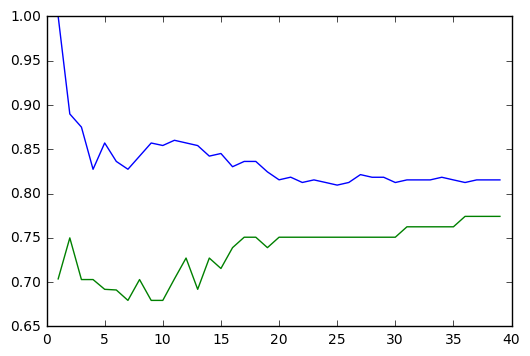

In [2867]:
plt.plot(N_neighbors,N_train_acc)
plt.plot(N_neighbors,N_test_acc)
plt.show()

In [2868]:
# Choose n_neighbors = 20. 

In [2869]:
# Plot ROC curve

# from sklearn import svm, datasets
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp

# # shuffle and split training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
#                                                     random_state=0)

# # Learn to predict each class against the other
# neigh = KNeighborsClassifier(n_neighbors=20)

# y_score = neigh.fit(X_train, y_train).decision_function(X_test)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [2870]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) #/,
#                                                    random_state=0)

In [2871]:
# X_train = np.array([train_data.MedLength,train_data.IqrAngle]).T
# X_test = np.array([test_data.MedLength,test_data.IqrAngle]).T
# y_train = train_data.Label.as_matrix()
# y_test = test_data.Label.as_matrix()

In [2872]:
len(X_test)

26

In [2873]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [2874]:
# Prediction
y_pred = neigh.predict(X)
y_pred_train = neigh.predict(X_train)
y_pred_test = neigh.predict(X_test)

In [2875]:
len(y_pred_test)

26

In [2876]:
# Training and test error
train_err = float(sum(y_pred_train==y_train))/len(y_train)
test_err = float(sum(y_pred_test==y_test))/len(y_test)
print train_err
print test_err

0.793103448276
0.807692307692


In [2877]:
# Precision and recall
P = np.where(y_test==1)[0]
N = np.where(y_test==0)[0]

P_pred = np.where(y_pred_test==1)[0]
N_pred = np.where(y_pred_test==0)[0]

TP = float(len(np.intersect1d(P,P_pred)))
TN = float(len(np.intersect1d(N,N_pred)))
FP = float(len(np.intersect1d(N,P_pred)))
FN = float(len(np.intersect1d(P,N_pred)))

prec = TP/(TP+FP)
recall = TP/(TP+FN)


Fscore = 2*prec*recall/(prec + recall)
acc = (TP + TN)/(TP + TN + FP + FN)

print prec
print recall # note: this is unbalanced by many more positive than negative examples
print Fscore
print acc


0.6
0.857142857143
0.705882352941
0.807692307692


In [2878]:
#high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

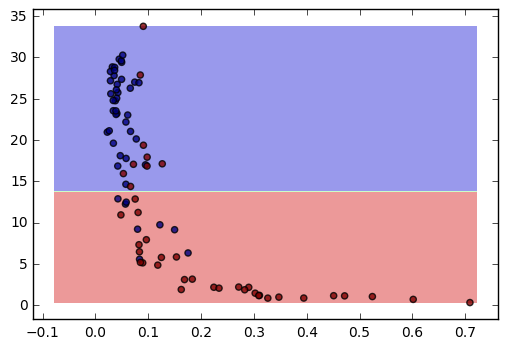

In [2879]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.show()
# axarr[idx[0], idx[1]].set_title(tt)

In [2880]:
# LOOK AT EDGE CASES OF FALSE PREDICTIONS

# Plot false positives and false negatives

FP_ix = np.intersect1d(N,P_pred)
FN_ix = np.intersect1d(P,N_pred)


In [2881]:
# Training error and test error as a function of n_neighbors

In [2882]:
# Pick number of neigbors using cross-validation

In [2883]:

# # SVM

# from sklearn.svm import SVC

# clf = SVC()
# model = clf.fit(X, y) 

# # decision boundary for just length
# xx = np.linspace(np.min(X),np.max(X),100)

# pred_prev = 0
# for x in xx:
#     pred = clf.predict(x)
#     if pred[0] > pred_prev:
#         x_dec = x
#         break
#     pred_prev = pred

# predictions = clf.predict(X)

# colors = ['g' if label else 'r' for label in data.Label]

# plt.scatter(data.Avglength,data.Stdangle,c=colors)
# plt.axis('equal')
# plt.xlabel('Average length')
# plt.ylabel('St. dev. in angle')
# # plt.plot([x_dec,x_dec],[np.min(data.Stdangle),np.max(data.Stdangle)])
# plt.axis('tight')
# plt.show()